# 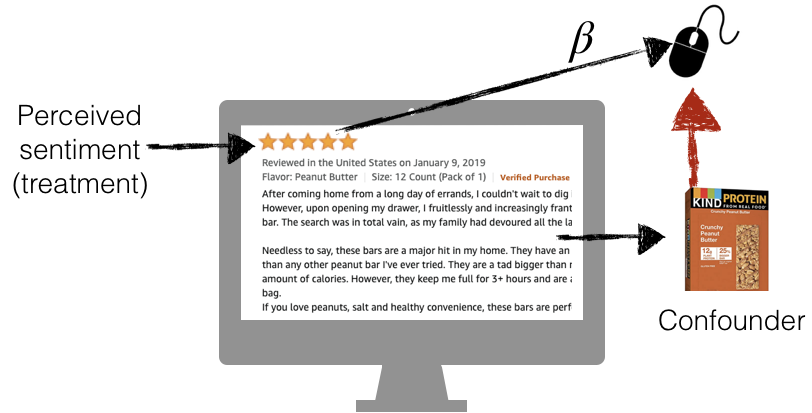

### **Setting**: For readers of product reviews, what is the causal effect of perceived sentiment of the review on product purchase?
*   These are Amazon reviews about CDs, MP3s, and Albums.
*   Outcome is a binary indicator for "buys product or not" and it's *simulated*.
*   The idea is that we'll use the true perceived sentiment and some other variables to simulate outcomes.
*   We'll assume that the product reviewer's given rating (4/5 versus 0/1 stars) effectively captures whether a reader would perceive the review to be positive or negative.
*  A simulated purchase will depend on both whether the reader thinks a review is positive or not, and whether a review is about CDs or not.
*  In this world, readers' purchase products when they perceive the review to be positive (this is the causal effect of interest), and if the product is a CD. It turns out that reviewers are generally more positive about CDs anyway. So from the correlation between perceived positive sentiment and outcomes alone, we can't tell apart the causal effect.


In [ ]:
!git clone https://github.com/dsridhar91/causal_text_effects_demo.git

Cloning into 'causal_text_effects_demo'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 3), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (14/14), done.


In [ ]:
%cd causal_text_effects_demo/src/

/content/causal_text_effects_demo/src


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
import os

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
input_fn = os.path.join('..', 'dat', 'music_preprocessed.csv')
simulated_data = pd.read_csv(input_fn)
simulated_data

,Unnamed: 0,index,id,rating,product,text,summary,price,T_true,T_proxy,C_true,Y_sim,Y_1,Y_0
0,0,5,0001388703,5.0,mp3 music,"clever,inspired and moving. this is a great al...",AWSOME,13.01,1,1,0,1,1,0
1,1,6,0001388703,5.0,audio cd,keith green is a bit of legend in some christi...,"Heartfelt, Passionate and Funny - Green is Mas...",13.01,1,1,1,1,0,1
2,2,7,0001388703,1.0,mp3 music,buy the cd. do not buy the mp3 album. downlo...,Buy the CD. Do not buy the MP3.,13.01,0,1,0,1,1,1
3,3,8,0001388703,5.0,mp3 music,takes me back to my childhood!,Love it!,13.01,1,0,0,1,1,1
4,4,15,0001377647,5.0,audio cd,i have fallen in love with john michael talbot...,Talbot a masterpiece,18.99,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21285,21285,55964,B01H6WCEK8,5.0,vinyl,brilliant set list and the guys sound awesome ...,BRILLIANT set list and the guys sound awesome ...,88.15,1,1,0,1,0,1
21286,21286,55965,B01H6WCEK8,5.0,vinyl,"the best kiss album yet,for the best price.",Five Stars,88.15,1,1,0,0,0,0
21287,21287,55973,B01HC5D4PS,1.0,audio cd,the reading of his poems are monotonous.,One Star,11.17,0,0,1,0,1,1
21288,21288,55977,B01HDRMCXK,5.0,audio cd,anton batagov is a renowned composer and piani...,Fresh piano sounds from established Glass comp...,18.99,1,1,1,1,1,0


In [ ]:
%less ../dat/positive-words.txt

# How can I use my own data?

*   As we'll see in this demo, the key ingredients are columns that contain the raw text, the proxy treatment, and the outcome.
* The relevant columns are:

```
text, T_proxy, Y_sim
```


### Calculating the true effect in a simulated setting

*   Since we're simulating the outcomes ourselves, we simulate both counterfactual outcomes, $Y(1) \sim P(Y;\text{do}(T=1))$ and $Y(0) \sim P(Y;\text{do}(T=0))$. 
*   We can do this by, e.g., setting the binary treatment indicator (i.e., perceived sentiment is positive or not) to 1 and evaluating the simulation model at that value, with all other parameters fixed.
* Then, by definition, the true average treatment effect (ATE) is, $\mathbb{E}[Y(1) - \mathbb{E}[Y(0)]$, which we'll approximate with the sample mean.

In [ ]:
print("True ATE:", simulated_data.Y_1.mean() - simulated_data.Y_0.mean())

True ATE: 0.15457961484264915


### Naive estimation


*   Our first proposal was to look at the mean difference in probability of purchases among the reviews where our proxy said review sentiment is positive and those where our proxy said sentiment is negative.
*   That is, $\mathbb{E}[Y|T_{\text{proxy}}=1] - \mathbb{E}[Y|T_{\text{proxy}}=0]$



In [ ]:
proxy_treated = simulated_data[simulated_data.T_proxy==1]
proxy_untreated = simulated_data[simulated_data.T_proxy==0]
ate_naive = proxy_treated.Y_sim.mean() - proxy_untreated.Y_sim.mean()
print("Naive estimate:", ate_naive)

Naive estimate: 0.07267059064186498


We see that the naive estimate differs from the true ATE by nearly half the magnitude! 

## Working with the text-adjusted estimator
*   Following the insights of the technical result, we'll adjust for the text.
*   We'll follow ideas from [causally sufficient embeddings](https://proceedings.mlr.press/v124/veitch20a.html), and learn causally-valid representations of text with topic models.
* We'll fit a topic model using variational autoencoders. The encoder will produce each document's topic proportions --- it's representation. 
* We train the encoder to produce representations that do three things well: i) model the log probability of the documents, ii) predict the outcomes for the documents where the proxy says positive sentiment, and iii) predict outcomes for documents where the proxy says negative sentiment.
* **Note:** As we learned in the talk, we're not going use the representation to predict the (proxy) treatment label, since we want to push the representation towards information that's **distinct** to sentiment.

At a high-level, here's the algorithm pseudocode we'll follow:

1.   Represent our texts as a term frequency (TF) matrix.
2.   Fit a topic model that takes as input the TF matrix, the proxy treatment label for each sample, and the outcome. That is, minimize a loss that penalizes errors in:
*   Reconstruction of the empirical term frequencies
*   Predicting outcomes for each of the $T_{\text{proxy}}
=1$ and $T_{\text{proxy}}=0$ groups of samples.
*   The KL divergence between the fitted distribution of document-topic vectors (the posterior over representations) and the prior. 
3. After the model is fitted, for all samples, predict the outcomes using **both** predictors. This is done by first putting the text through the trained encoder to produce a representation, and then passing the representation to the predictors. The idea is that the predictors are approximating each text's counterfactual outcomes had the proxy treatment been positive versus negative sentiment.
4. Take the difference of these predictions, and average over differences across samples.


### Step 1: Represent our texts as a term frequency (TF) matrix.

In [ ]:
text = simulated_data.text.values
vec = CountVectorizer(min_df=0.0005, max_df=0.95, stop_words=stopwords.words('english'))
counts = vec.fit_transform(text)
vocab = np.array(vec.get_feature_names_out())
counts = counts.toarray()
print("Num. documents:", counts.shape[0], "Vocab. size:", counts.shape[1])

Num. documents: 21290 Vocab. size: 6505


Let's remove any documents where the total term count is 0.

In [ ]:
valid = (counts.sum(axis=1) > 0)
counts = counts[valid, :]
outcomes = simulated_data.Y_sim.values
treatment_labels = simulated_data.T_proxy.values
treatment_labels = treatment_labels[valid]
outcomes = outcomes[valid]

### Step 2: Fit a topic model to predict the log probability of the document and the outcomes based on the representation.

In [ ]:
import supervised_topic_model as stm
import model_trainer

In [ ]:
num_topics = 10
num_documents = counts.shape[0]
vocab_size = counts.shape[1]
model = stm.SupervisedTopicModel(num_topics, 
                             vocab_size, 
                             num_documents, 
                             outcome_linear_map=False)

model_trainer.train(model, 
                    counts, 
                    treatment_labels, 
                    outcomes, 
                    num_iters=300, 
                    use_recon_loss=True, 
                    use_outcome_loss=True,
                    use_treatment_loss=False,
                    is_label_binary=True,
                    lr=0.01)

Acc. loss: 305.00152587890625 KL loss.: 2.4920146465301514 Outcome loss: 1.4480578899383545 Treatment loss: 0.0
Acc. loss: 309.66143798828125 KL loss.: 1.0567206144332886 Outcome loss: 1.3070787191390991 Treatment loss: 0.0
Acc. loss: 328.065185546875 KL loss.: 0.8293584585189819 Outcome loss: 1.2913621664047241 Treatment loss: 0.0
Acc. loss: 225.4784698486328 KL loss.: 0.6387832164764404 Outcome loss: 1.2586225271224976 Treatment loss: 0.0
Acc. loss: 268.85791015625 KL loss.: 0.593940258026123 Outcome loss: 1.323628306388855 Treatment loss: 0.0
Acc. loss: 313.1370849609375 KL loss.: 0.775471568107605 Outcome loss: 1.2724252939224243 Treatment loss: 0.0
Acc. loss: 260.6757507324219 KL loss.: 0.674327552318573 Outcome loss: 1.2545166015625 Treatment loss: 0.0
Acc. loss: 259.616943359375 KL loss.: 0.676960825920105 Outcome loss: 1.3087048530578613 Treatment loss: 0.0
Acc. loss: 260.8432312011719 KL loss.: 0.7297844886779785 Outcome loss: 1.31108558177948 Treatment loss: 0.0
Acc. loss: 28

### Step 3: For **all** documents (i.e., reviews), predict the  outcome had the document been "treated" (i.e., received a positive sentiment prediction by the proxy), and the outcome had it not been treated.

In [ ]:
_, expected_outcome_treat, expected_outcome_no_treat = model_trainer.predict(model, counts, is_label_binary=True)

### Step 4: Take the difference of these predictions, and average over differences across samples.

In [ ]:
ate_adjusted = (expected_outcome_treat - expected_outcome_no_treat).mean()
print("ATE estimate after text adjustment:", ate_adjusted)

ATE estimate after text adjustment: 0.15685806


One of the benefits of fitting topic models is that we can  readily inspect the model. We can visualize the fitted topics, for example.

In [ ]:
model_trainer.visualize_topics(model, vocab, num_topics)

####################################################################################################
Visualize topics...
Topic 0: ['two' 'even' 'real' 'listen' '10' 'also' 'la' 'playing' 'years' 'new']
Topic 1: ['sound' 'good' 'see' 'got' 'think' 'thought' 'every' 'album' 'songs'
 'different']
Topic 2: ['well' 'album' 'right' 'data' 'new' 'feel' 'normal' 'two' 'track'
 'little']
Topic 3: ['bit' 'since' 'recording' 'de' 'fan' 'back' 'much' 'song' 'like' 'would']
Topic 4: ['always' 'new' 'find' 'album' 'disc' 'available' 'good' 'sure' 'sounds'
 'really']
Topic 5: ['many' 'music' 'listening' 'get' 'voice' 'quality' 'one' 'time' 'great'
 'lp']
Topic 6: ['solo' 'really' 'recording' 'music' 'perfect' 'good' 'love' 'album'
 'first' 'sound']
Topic 7: ['far' 'use' 'find' 'since' 'still' 'disc' 'collection' 'sound' 'like'
 'love']
Topic 8: ['high' 'ever' 'played' 'wonderful' 'definitely' 'back' 'great' 'cd'
 'excellent' 'even']
Topic 9: ['way' 'orchestra' 'rock' 'bought' 'nice' 'much' 'time' 'fa